In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import repeat
from extra_packages.OutputInterface import OutputInterface
import extra_packages.sperhical_expansion as se
import SFALinearPulse as SFA_Lin
from matplotlib.colors import LogNorm
from scipy.special import sph_harm

In [2]:
import multiprocessing
#import ipyparallel as ipp
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
pool = multiprocessing.Pool(processes=cpus)

In [3]:
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2     # This choice should make things symmetric

### Some utility functions

In [4]:
def plot_M_grid(M_grid, px_list, pz_list, log=False, log_scale = 1e-4):
    """
    Function to plot the calculated grids
    """
    plt.figure(facecolor='white', figsize=(12,6))

    M2_grid = np.abs(M_grid)**2
    MMax = np.max(M2_grid)

    if log:
        plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
                   cmap='inferno', norm=LogNorm(vmin=MMax*log_scale, vmax=MMax),
                   interpolation = 'bicubic', aspect = 1.)
    else:
        plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
                   cmap='inferno', interpolation = 'bicubic', aspect = 1.)

    plt.ylabel("$p_x$")
    plt.xlabel("$p_z$")
    plt.colorbar()
    plt.show()

def hyd1s(r, theta, phi):
    """
    Radial function for ground state hydrogen
    """
    return 1/np.sqrt(np.pi) * np.exp(-r)

### Load the GAMESS GTO expansion of ground state hydrogen for testing!
This expansion is of course not perfect - fx the Ip does not equal 0.5. We can always fix this with a better basis.

In [31]:
file_name = 'output_files/Hydrogen.out'
output = OutputInterface(file_name)
Ip = -output.saved_orbitals[output.HOMO][0]  # Should we put this to 1/2?
kappa = np.sqrt(2*Ip)
GTO_coeffs = np.array(output.output_GTOs())

#### Fit to the asymptotic form
Here we match the asymptotic coeffs. to the GTO expansion. We use the same Ip as from GAMESS here.

N should be an even number! Incrementing by one


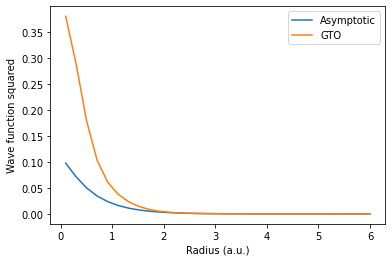

In [32]:
clm_array_GTO = se.get_as_coeffs(output.eval_orbital_spherical, 2.5, 15, Ip)

phi = 0
theta = 0

n_r = 30
r_lst = np.linspace(0.1, 6, n_r)

plt.figure(facecolor='white')
plt.plot(r_lst, np.abs(se.eval_asymptotic(r_lst, theta, phi, clm_array_GTO, Ip))**2, label='Asymptotic')
plt.plot(r_lst, np.abs(output.eval_orbital_spherical(r_lst, theta, phi))**2, label='GTO')
#plt.plot(r_lst, np.abs(hyd_1s(r_lst, 0., 0.))**2, label='Analytic Hydrogen')
plt.legend()
plt.xlabel('Radius (a.u.)')
plt.ylabel('Wave function squared')
plt.show()

#### Asymptotic form matched directly to the 1s state of hydrogen
Here we use the real Ip = 0.5

N should be an even number! Incrementing by one


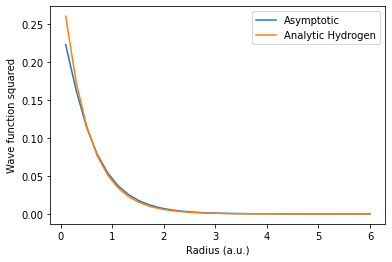

In [33]:
clm_array_analytic = se.get_as_coeffs(hyd1s, 2.5, 15, 0.5)

phi = 0
theta = 0

plt.figure(facecolor='white')
plt.plot(r_lst, np.abs(se.eval_asymptotic(r_lst, theta, phi, clm_array_analytic, Ip))**2, label='Asymptotic')
#plt.plot(r_lst, np.abs(output.eval_orbital_spherical(r_lst, theta, phi))**2, label='GTO')
plt.plot(r_lst, np.abs(hyd1s(r_lst, 0., 0.))**2, label='Analytic Hydrogen')
plt.legend()
plt.xlabel('Radius (a.u.)')
plt.ylabel('Wave function squared')
plt.show()

## Time to calculate with different prefactors!

In [34]:
N = 50
pz_list = np.linspace(-1.5, 1.5, 2*N)
px_list = np.linspace(0, 1., N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.

## Analytical expression for ground state hydrogen with numerical integration:
This is (76) in the review by Milosevic ('Above-threshold ionization by few-cycle pulses'). This is the analytical SFA expression, and we here do the integration numerically to avoid extra assumptions from the saddle point approximation (SPA).

In [12]:
SP_1s_num  = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="hyd1s_analytic")
M_1s_num = np.array(pool.starmap(SP_1s_num.Mxz_List_num, zip(pxGrid, repeat(py), pzGrid)))

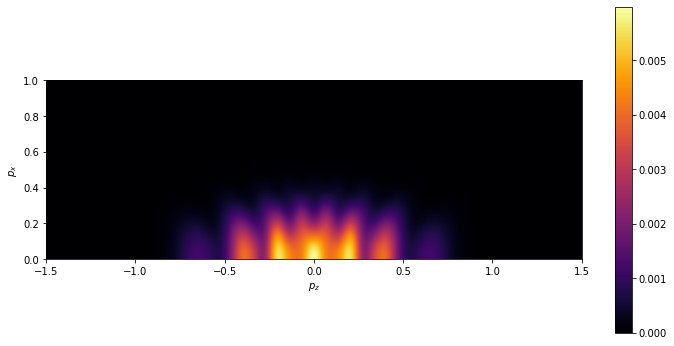

In [13]:
plot_M_grid(M_1s_num, px_list, pz_list)

### With GAMESS GTO expansion in SPA
The ampltiude here does not match perfectly - but it is not that far off either. The shape is pretty much the same!

In [14]:
SP_GTO = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="GTO")
M_GTO = np.array(pool.starmap(SP_GTO.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(GTO_coeffs))))

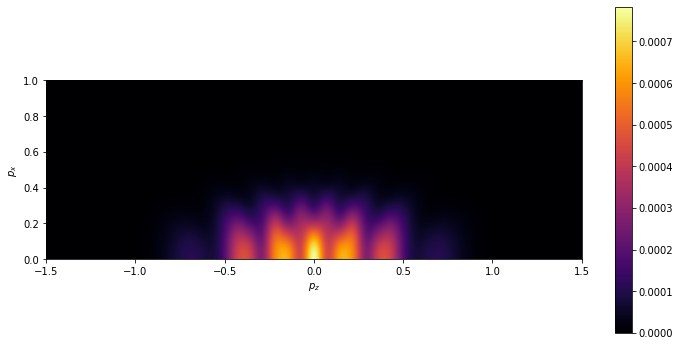

In [15]:
plot_M_grid(M_GTO, px_list, pz_list)

### With GTO numerically
Here the amplitude is actually worse than the SPA...

In [16]:
M_GTO_num = np.array(pool.starmap(SP_GTO.Mxz_List_num, zip(pxGrid, repeat(py), pzGrid, repeat(GTO_coeffs))))

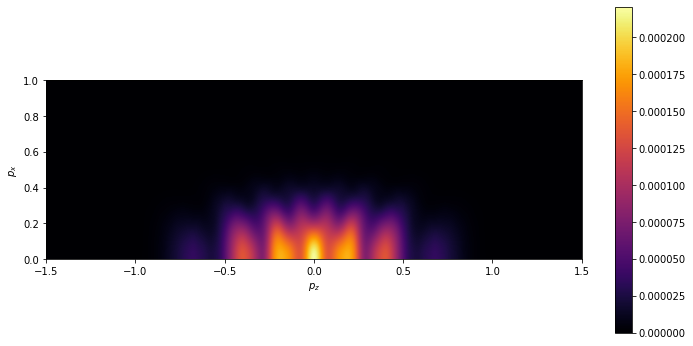

In [17]:
plot_M_grid(M_GTO_num, px_list, pz_list)

### Shifted hydrogen away from origin - GTO, SPA
We want to test the 'curse of the displaced atom', which is clearly present in our GTO prefactor. So here we shift the hydrogen atom up in z by 2 a.u. The effect is very visible, and this is not good, as is should not depend on where we place our atom?
We tested with displacement along x and y but this does not seem to matter, only displancement along z (the polarization direction of the light). The effect is almost the same for a displacement of 1 a.u., which is not an unrealistic value for interatomic distance in the molecular data we have from GAMESS.

In [18]:
x0, y0, z0 = (0, 0, 2)  # Shift of hydrogen atom
shift_GTO_coeffs = GTO_coeffs.copy()
shift_GTO_coeffs[:,-3] = x0
shift_GTO_coeffs[:,-2] = y0
shift_GTO_coeffs[:,-1] = z0

In [19]:
SP_GTO_shift = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="GTO")
M_GTO_shift = np.array(pool.starmap(SP_GTO_shift.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(shift_GTO_coeffs))))

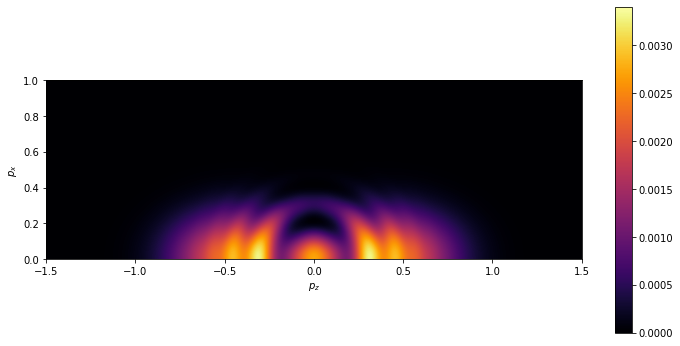

In [20]:
plot_M_grid(M_GTO_shift, px_list, pz_list)

### Same as above, but numerically
Bojer pointed out, that it might be possible to modify the SPA with the extra exponential terms that we get in our prefactor. Here we tested if this was the problem, by just avoiding the SPA alltogether. The problem is still there, and thus not an effect from the SPA. Note however that the SPA and the numerical values are about an order of magnitude apart, this could be because of the missing correction of the SPA?

In [21]:
SP_GTO_shift_num = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="GTO")
M_GTO_shift_num = np.array(pool.starmap(SP_GTO_shift.Mxz_List_num, zip(pxGrid, repeat(py), pzGrid, repeat(shift_GTO_coeffs))))

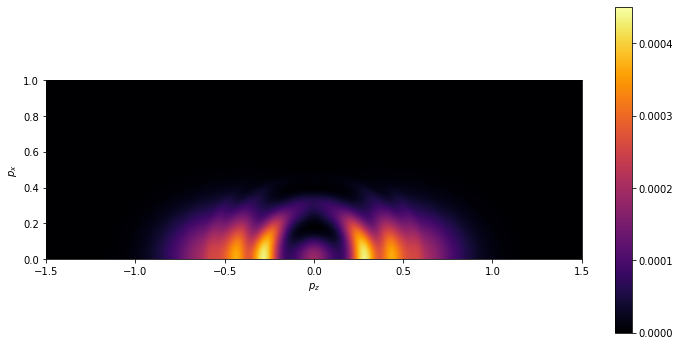

In [22]:
plot_M_grid(M_GTO_shift_num, px_list, pz_list)

This does not look good. The shift has a huge effect on the transition amplitude, but only in the direction of polarization of the laser.
Let's see if the asymptotic version is effected in the same way...

### With Martiny's asymptotic version
We calculated the asymptotic prefactor with the method in Milosevic, and it is in fact exactly what is found in Martiny's phd thesis. So here we call it by his name (we have another asymptotic prefactor in the code that is not used here...).

#### First using the expansion of the GTO WF
Here we use the asymptotic coeffs. found from the GTO expansion.

In [35]:
SP_asymp_martiny = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")
M_asymp_martiny = np.array(pool.starmap(SP_asymp_martiny.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_GTO))))

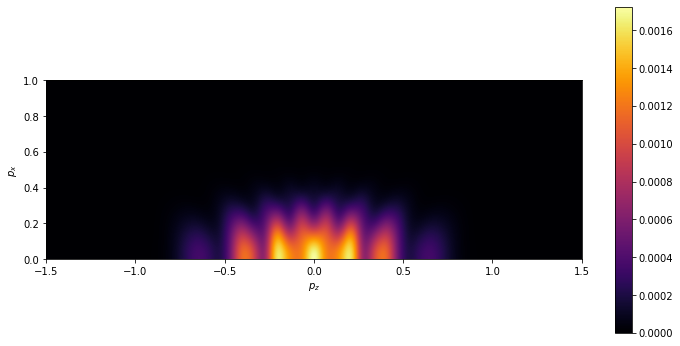

In [36]:
plot_M_grid(M_asymp_martiny, px_list, pz_list)

#### And then using the expansion of the analytical WF
And here the ones from the analytical expression. Again it all looks like it should, and the values are quite close togehter. The difference is probably because of the different values of Ip...

In [27]:
M_asymp_martiny = np.array(pool.starmap(SP_asymp_martiny.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_analytic))))

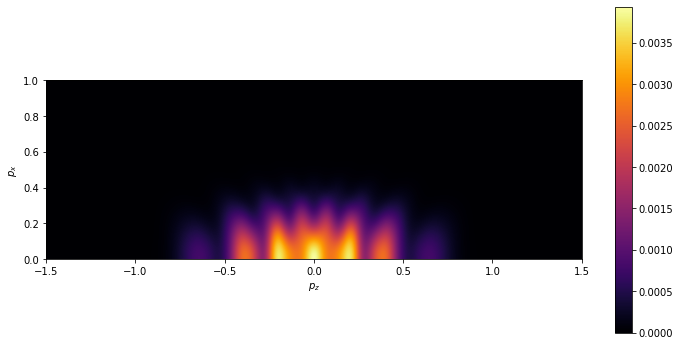

In [28]:
plot_M_grid(M_asymp_martiny, px_list, pz_list)

## Last let's try to chech if the shift has the same effect on the asymptotic expression (we would think so).
First we need to shift the GTO expansion in the class:

In [11]:
output_shifted = OutputInterface(file_name)
output_shifted.basis_funcs = []  # Reset the basis functions
output_shifted.position[1] = [0.0, 0.0, 1.0]  # Set new atomic position
output_shifted.make_basis_functions()  # Make the basis functions, now with new position

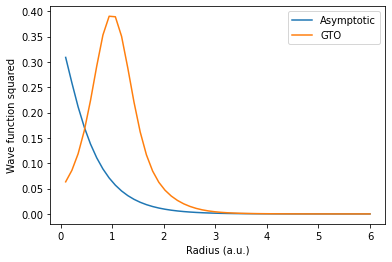

In [45]:
clm_array_GTO_shifted = se.get_as_coeffs(output_shifted.eval_orbital_spherical, 5, 30, Ip)  # Increased the radius at which we pick the values

phi = 0
theta = 0#np.pi

n_r = 50
r_lst = np.linspace(0.1, 6, n_r)

plt.figure(facecolor='white')
plt.plot(r_lst, np.abs(se.eval_asymptotic(r_lst, theta, phi, clm_array_GTO_shifted, Ip))**2, label='Asymptotic')
plt.plot(r_lst, np.abs(output_shifted.eval_orbital_spherical(r_lst, theta, phi))**2, label='GTO')
#plt.plot(r_lst, np.abs(hyd_1s(r_lst, 0., 0.))**2, label='Analytic Hydrogen')
plt.legend()
plt.xlabel('Radius (a.u.)')
plt.ylabel('Wave function squared')
plt.show()

The above looks a bit funny, the asymptotic rises towards 0 while the GTO is located around 1. But this is what we would expect, since the asymptotic expresion is only valid far out anyways... Let's try to calculate the transition ampltuides:

In [42]:
M_asymp_martiny_shifted = np.array(pool.starmap(SP_asymp_martiny.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_GTO_shifted))))

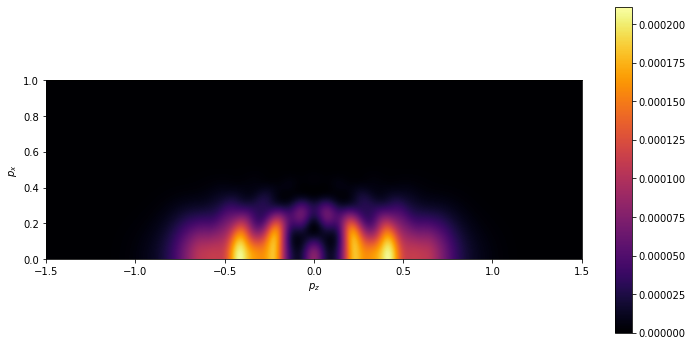

In [43]:
plot_M_grid(M_asymp_martiny_shifted, px_list, pz_list)

This actually looks quite a lot like the shifted GTO expression. So the problem is of course still here...!

### Let's try for a molecule!

In [5]:
file_name_ch = 'output_files/CHBrClF.out'
output_ch = OutputInterface(file_name_ch)
Ip_ch = -output_ch.saved_orbitals[output_ch.HOMO][0]
kappa_ch = np.sqrt(2*Ip_ch)
GTO_coeffs_ch = np.array(output_ch.output_GTOs())

In [49]:
n_r = 50
n_l = 30
r_lst = np.linspace(1, 25, n_r)
f_lms = []
for i, r in enumerate(r_lst):
    print(f'Evaluating at r={r:.4f} \t Nr. {i+1}/{n_r}')
    f_lms.append(se.spherical_expansion(lambda theta, phi: output_ch.eval_orbital_spherical(r, theta, phi), 50))
f_lms = np.array(f_lms)

Evaluating at r=1.0000 	 Nr. 1/50
Evaluating at r=1.4898 	 Nr. 2/50
Evaluating at r=1.9796 	 Nr. 3/50
Evaluating at r=2.4694 	 Nr. 4/50
Evaluating at r=2.9592 	 Nr. 5/50
Evaluating at r=3.4490 	 Nr. 6/50
Evaluating at r=3.9388 	 Nr. 7/50
Evaluating at r=4.4286 	 Nr. 8/50
Evaluating at r=4.9184 	 Nr. 9/50
Evaluating at r=5.4082 	 Nr. 10/50
Evaluating at r=5.8980 	 Nr. 11/50
Evaluating at r=6.3878 	 Nr. 12/50
Evaluating at r=6.8776 	 Nr. 13/50
Evaluating at r=7.3673 	 Nr. 14/50
Evaluating at r=7.8571 	 Nr. 15/50
Evaluating at r=8.3469 	 Nr. 16/50
Evaluating at r=8.8367 	 Nr. 17/50
Evaluating at r=9.3265 	 Nr. 18/50
Evaluating at r=9.8163 	 Nr. 19/50
Evaluating at r=10.3061 	 Nr. 20/50
Evaluating at r=10.7959 	 Nr. 21/50
Evaluating at r=11.2857 	 Nr. 22/50
Evaluating at r=11.7755 	 Nr. 23/50
Evaluating at r=12.2653 	 Nr. 24/50
Evaluating at r=12.7551 	 Nr. 25/50
Evaluating at r=13.2449 	 Nr. 26/50
Evaluating at r=13.7347 	 Nr. 27/50
Evaluating at r=14.2245 	 Nr. 28/50
Evaluating at r=14.7

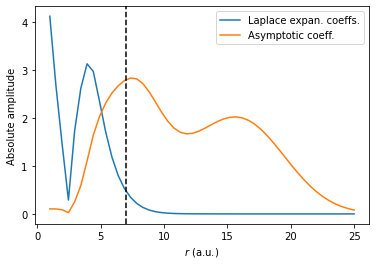

In [50]:
def radial(r):
    return r**(1/kappa_ch - 1) * np.exp(-kappa_ch*r)

plt.figure(facecolor='white')
sgn, l, m = 0, 1, 1
plt.plot(r_lst, np.abs(f_lms[:, sgn, l, m])*100, label='Laplace expan. coeffs.')
plt.plot(r_lst, np.abs(f_lms[:, sgn, l, m]) / radial(r_lst), label='Asymptotic coeff.')
plt.axvline(7, ls='--', color='k')                              # r = 7 seems like a solid choice!
plt.xlabel('$r$ (a.u.)')
plt.ylabel('Absolute amplitude')
plt.legend()
plt.show()

In [21]:
clm_array_ch_7 = se.get_as_coeffs(output_ch.eval_orbital_spherical, 7, 50, Ip_ch, abs_thresh=1e-8)
clm_array_ch_16 = se.get_as_coeffs(output_ch.eval_orbital_spherical, 16, 50, Ip_ch, abs_thresh=1e-8)

In [7]:
N = 50
pz_list = np.linspace(-1.5, 1.5, N)
px_list = np.linspace(-1, 1., N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.

In [8]:
SP_asymp_ch = SFA_Lin.SFALinearPulse(Ip_ch, Up, omega, 2, CEP, target_="asymp_martiny")
SP_GTO_ch = SFA_Lin.SFALinearPulse(Ip_ch, Up, omega, 2, CEP, target_="GTO")

## First with the GTO

In [9]:
M_GTO_ch = np.array(pool.starmap(SP_GTO_ch.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(GTO_coeffs_ch))))

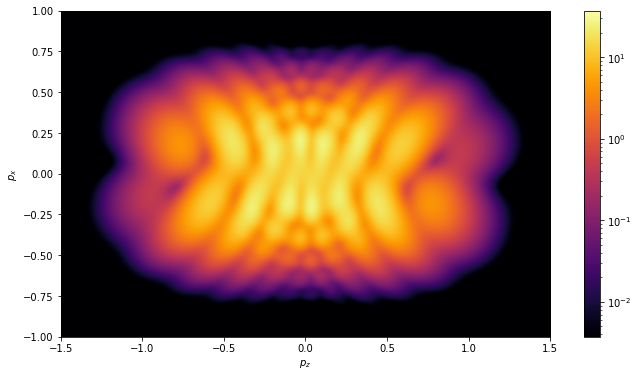

In [11]:
plot_M_grid(M_GTO_ch, px_list, pz_list, log=True)

## Then with the asymptotic
We also try to sample the asymptotic coefficients at two different spots: One at r=7 and one at r=16 (the peaks in the asymp_coeff plot above).


In [22]:
M_asymp_ch_7 = np.array(pool.starmap(SP_asymp_ch.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_ch_7))))

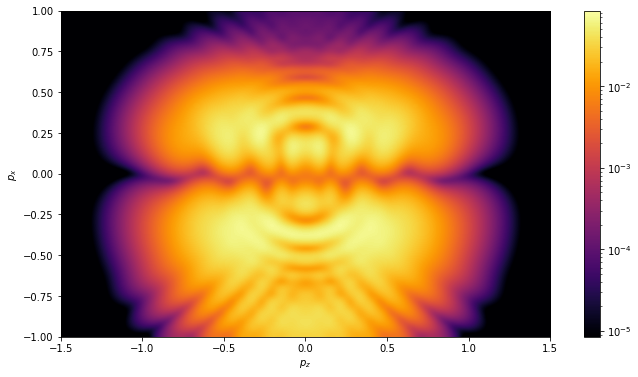

In [23]:
plot_M_grid(M_asymp_ch_7, px_list, pz_list, log=True)

Holy smokes...

In [15]:
M_asymp_ch_16 = np.array(pool.starmap(SP_asymp_ch.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_ch_16))))

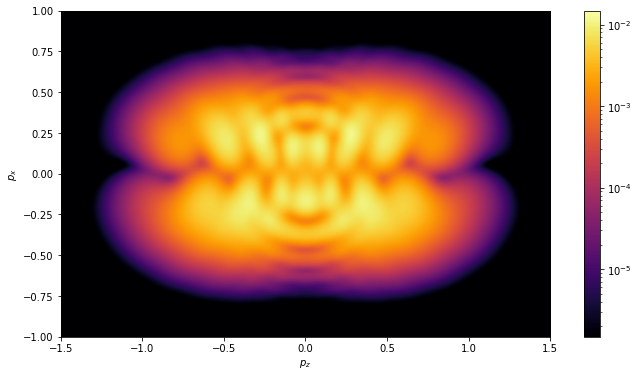

In [17]:
plot_M_grid(M_asymp_ch_16, px_list, pz_list, log=True)

This may look a bit better... So it seems we should also be quite carefull about picking the right spot for the Clm's. Maybe we need to do for the individual ones instead of taking them all at the same point.
The  asymptotic ones does not have the asymmetry in the pz direction as the GTO one has...